In [1]:
#!pip install backtrader

In [2]:
from datetime import datetime
import backtrader as bt
import matplotlib
import pandas as pd
import math

matplotlib.__version__

'3.2.2'

Buy Signal:

* Price > Tenkan
* Price > Kijun

* Tenkan > Kijun

* Price > SenkoA
* Price > SenkoB

* Tenkan > SenkoA
* Tenkan > SenkoB

* Kijun > SenkoA
* Kijun > SenkoB

* SenkoA > SenkoB

* Chikou > price 26 days ago
* Chikou projected 10 days out should not be lower than price 10 days ago

* teankan pointing up
* kijun pointing up
* chikou pointing up
* future senkouA pointing up
* future senkouB pointing up

Sell Signal:

* Price < Tenkan
* Price < Kijun

* Tenkan < Kijun

* Price < SenkoA
* Price < SenkoB

* Tenkan < SenkoA
* Tenkan < SenkoB

* Kijun < SenkoA
* Kijun < SenkoB

* SenkoA < SenkoB

* Chikou < price 26 days ago
* Chikou projected 10 days out should not be higher than price 10 days ago

* teankan pointing down
* kijun pointing down
* chikou pointing down
* future senkouA pointing down
* future senkouB pointing down

In [3]:
cerebro = bt.Cerebro()

In [4]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    
    params = (
                ('tenkan', 9),
                ('kijun', 26),
                ('senkou', 52),
                ('senkou_lead', 26),  # forward push
                ('chikou', 26),  # backwards push
            )

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.f_senkou_b_t_minus_one = math.nan
        
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a Ichimoku indicator
        self.ichimoku = bt.indicators.Ichimoku(self.datas[0],
                                           tenkan=self.params.tenkan,
                                           kijun=self.params.kijun,
                                           senkou=self.params.senkou,
                                           senkou_lead=self.params.senkou_lead,
                                           chikou=self.params.chikou)
    

    def log(self, txt, dt=None):
        '''Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm 
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}')
    
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset order status to prepare for next order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}')

    def next(self):
        # Simply log the closing price of the series from the reference
        # self.log(f'Close, {self.dataclose[0]}')

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # Price > Tenkan
            condition1 = self.dataclose[0] > self.ichimoku.tenkan_sen[0]

            # Price > Kijun
            condition2 = self.dataclose[0] > self.ichimoku.kijun_sen[0]

            # Tenkan > Kijun
            condition3 = self.ichimoku.tenkan_sen[0] > self.ichimoku.kijun_sen[0]

            # Price > SenkoA
            condition4 = self.dataclose[0] > self.ichimoku.senkou_span_a[0]

            # Price > SenkoB
            condition5 = self.dataclose[0] > self.ichimoku.senkou_span_b[0]

            # Tenkan > SenkoA
            condition6 = self.ichimoku.tenkan_sen[0] > self.ichimoku.senkou_span_a[0]

            # Tenkan > SenkoB
            condition7 = self.ichimoku.tenkan_sen[0] > self.ichimoku.senkou_span_b[0]

            # Kijun > SenkoA
            condition8 = self.ichimoku.kijun_sen[0] > self.ichimoku.senkou_span_a[0]

            # Kijun > SenkoB
            condition9 = self.ichimoku.kijun_sen[0] > self.ichimoku.senkou_span_b[0]

            # SenkoA > SenkoB
            condition10 = self.ichimoku.senkou_span_a[0] > self.ichimoku.senkou_span_b[0]

            # Chikou > price 26 days ago
            condition11 = self.ichimoku.chikou_span[-26] > self.dataclose[-26]

            # teankan pointing up
            condition12 = self.ichimoku.tenkan_sen[0] > self.ichimoku.tenkan_sen[-1]

            # kijun pointing up
            condition13 = self.ichimoku.kijun_sen[0] > self.ichimoku.kijun_sen[-1]

            # chikou pointing up
            condition14 = self.ichimoku.chikou_span[-26] > self.ichimoku.chikou_span[-27]
            
            # future senkouA pointing up
            f_senkou_a = self._senkou_span_a(tenkan_sen=self.ichimoku.l.tenkan_sen.get(size=26),
                               kijun_sen=self.ichimoku.l.kijun_sen.get(size=26))
            
            condition15 = f_senkou_a[25] > f_senkou_a[24]
            

            # future senkouB pointing up
            f_senkou_b = self._senkou_span_b([self.datas[0].close[i] for i in range(0, -52, -1)])
            self.f_senkou_b_t_minus_one = f_senkou_b
            
            condition16 = f_senkou_b > self.f_senkou_b_t_minus_one
            
            # Chikou projected 10 days out should not be lower than price 10 days ago
            condition17 = self.ichimoku.chikou_span[-26] > self.dataclose[-16]
            

            # Not yet ... we MIGHT BUY if ...
            if condition1 and condition2 and condition3 and condition4 and condition5\
            and condition6 and condition7 and condition8 and condition9 and condition10\
            and condition11 and condition12 and condition13 and condition14 and condition15:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log(f'BUY CREATE, {self.dataclose[0]}')

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:
            condition1 = self.ichimoku.chikou_span[-26] < self.dataclose[-26]
            
            condition2 = self.ichimoku.tenkan_sen[0] < self.ichimoku.kijun_sen[0]
            
            condition3 = self.dataclose[0] < self.ichimoku.kijun_sen[0]
            
            if condition1 and condition2 and condition3:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log(f'SELL CREATE, {self.dataclose[0]}')

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    @staticmethod
    def _senkou_span_a(tenkan_sen,kijun_sen):        
        # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
        return ((pd.Series(tenkan_sen) + pd.Series(kijun_sen)) / 2)
    
    @staticmethod
    def _senkou_span_b(price):        
        # Senkou Span B (Leading Span B): (Highest High + Lowest Low)/2))
        return ((pd.Series(price).max() + pd.Series(price).min()) / 2)
    
#     def next(self):
#         self.log(f'========================================')
#         self.log(f'Today Close, {self.dataclose[0]}')
#         self.log(f'Today Tenkan, {self.ichimoku.tenkan_sen[0]}')
#         self.log(f't-1 Tenkan, {self.ichimoku.tenkan_sen[-1]}')
#         self.log(f'Today Kijun, {self.ichimoku.kijun_sen[0]}')
#         self.log(f't-1 Kijun, {self.ichimoku.kijun_sen[-1]}')
#         self.log(f'26 day ago Chikou, {self.ichimoku.chikou_span[-26]}')
#         self.log(f'27 day ago Chikou, {self.ichimoku.chikou_span[-27]}')
#         self.log(f'26 day ago Close, {self.dataclose[-26]}')
#         self.log(f'16 day ago Close, {self.dataclose[-16]}')
#         self.log(f'Today SenkouA, {self.ichimoku.senkou_span_a[0]}')
#         self.log(f'Today SenkouB, {self.ichimoku.senkou_span_b[0]}')
        
            
#         f_senkou_a = self._senkou_span_a(tenkan_sen=self.ichimoku.l.tenkan_sen.get(size=26),
#                                        kijun_sen=self.ichimoku.l.kijun_sen.get(size=26))
        
#         f_senkou_b = self._senkou_span_b([self.datas[0].close[i] for i in range(0, -52, -1)])       
        
#         self.log(f'Future SenkouA {f_senkou_a[25]}')
#         self.log(f'Future SenkouA t-1 {f_senkou_a[24]}')
#         self.log(f'Future SenkouB {f_senkou_b}')
        
#         self.log(f'Future SenkouB t-1 {self.f_senkou_b_t_minus_one}')
#         self.f_senkou_b_t_minus_one = f_senkou_b
#         #self.log(f'Last 52 days price {[self.datas[0].close[i] for i in range(0, -52, -1)]}')

In [5]:
# Add a strategy
cerebro.addstrategy(TestStrategy)

0

In [6]:
data = bt.feeds.YahooFinanceData(dataname='^NSEI', fromdate=datetime(2010, 1, 1),
                                  todate=datetime(2021, 2, 23))
cerebro.adddata(data)

In [7]:
cerebro.broker.setcash(10_00_000.0)

In [8]:
# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=3) #buy/sell 3 futures

In [9]:
# Set the commission - Rs 20 per transcation
cerebro.broker.setcommission(commission=20, margin=1_70_000)

In [10]:
starting = cerebro.broker.getvalue()
print(f'Starting Portfolio Value: {starting}')

Starting Portfolio Value: 1000000.0


In [11]:
%%time
cerebro.run()

2010-08-04, BUY CREATE, 5467.85
2010-08-05, BUY EXECUTED, Price: 5470.149999999999, Cost: 510000.0, Comm 60.0
2010-10-28, SELL CREATE, 5987.7
2010-10-29, SELL EXECUTED, Price: 6021.149999999999, Cost: 510000.0, Comm 60.0
2010-10-29, OPERATION PROFIT, GROSS: 1653.0000000000027, NET: 1533.0000000000027
2012-08-08, BUY CREATE, 5338.0
2012-08-09, BUY EXECUTED, Price: 5348.3, Cost: 510000.0, Comm 60.0
2012-11-22, SELL CREATE, 5627.75
2012-11-23, SELL EXECUTED, Price: 5635.45, Cost: 510000.0, Comm 60.0
2012-11-23, OPERATION PROFIT, GROSS: 861.4499999999989, NET: 741.4499999999989
2012-12-05, BUY CREATE, 5900.5
2012-12-06, BUY EXECUTED, Price: 5926.3, Cost: 510000.0, Comm 60.0
2013-02-11, SELL CREATE, 5897.85
2013-02-12, SELL EXECUTED, Price: 5894.350000000001, Cost: 510000.0, Comm 60.0
2013-02-12, OPERATION PROFIT, GROSS: -95.84999999999945, NET: -215.84999999999945
2013-10-30, BUY CREATE, 6251.7
2013-10-31, BUY EXECUTED, Price: 6237.149999999999, Cost: 510000.0, Comm 60.0
2013-11-21, SELL C

In [12]:
ending = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {ending}')

Final Portfolio Value: 1012515.7000000008


In [13]:
print(f'Returns: {round(((ending - starting)/starting)*100, 2)}%')

Returns: 1.25%


<IPython.core.display.Javascript object>


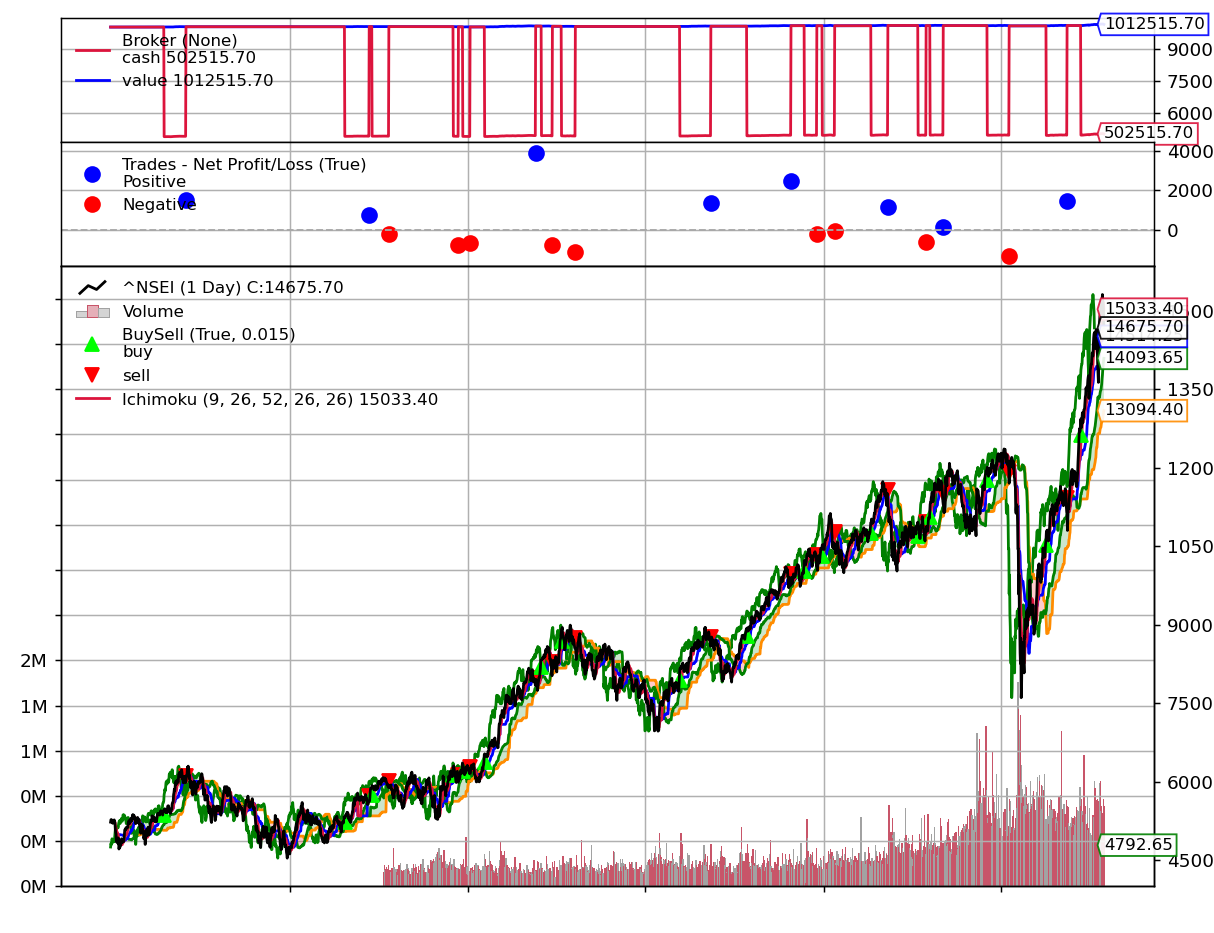

[[<Figure size 640x480 with 4 Axes>]]

In [14]:
cerebro.plot()